In [10]:
import sys
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from scripts.bloom_gen import BloomQuestionGenerator
from scripts.chunk import TextChunker, PDFChunker

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test Bloom Question Generation

In [11]:
with open('../data/AI_Articles/Artificial intelligence.txt', 'r') as file:
    text = file.read()

In [19]:
chunker = TextChunker(text, output_document=True)
chunks = chunker.recursive_chunk(chunk_size=256, by_tokens=True)
print(len(chunks))
print(chunks[0])

106
[Document(metadata={'type': 'text'}, page_content='Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals. Such machines may be called AIs.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., ChatGPT and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being called AI becau

In [22]:
bloom_generator = BloomQuestionGenerator()
question = bloom_generator.generate_question_2(chunks[0], question_type="MCQ", level=5, prompt_type="basic")
print(json.dumps(question, indent=2))

{
  "question": "Which of the following statements best evaluates the impact of AI on our daily lives?",
  "choices": {
    "A": "AI has little to no impact on our daily lives as its applications are limited.",
    "B": "AI is only used in high-profile applications such as autonomous vehicles and virtual assistants.",
    "C": "AI has a significant impact on our daily lives, with its influence often going unnoticed as it becomes common and useful.",
    "D": "AI is only used in the field of computer science research and has no practical applications."
  },
  "answer": "C"
}


In [9]:
question = bloom_generator.generate_question(chunks[0], question_type="SAQ", level=2, prompt_type="desc")
print(json.dumps(question, indent=2))

{
  "question": "What is the purpose of developing methods and software in the field of artificial intelligence research?",
  "correct_answer": "The purpose is to enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.",
  "incorrect_answer": "The purpose is to make machines capable of replacing human beings in all tasks."
}


In [10]:
question = bloom_generator.generate_question(chunks[0], question_type="SAQ", level=6, prompt_type="desc_examples")
print(json.dumps(question, indent=2))

{
  "question": "Imagine you have been tasked with developing a novel application for artificial intelligence. What would your application be, how would it use the principles of AI to function, and what goals would it aim to achieve?",
  "correct_answer": "A possible application could be an AI-based personal health advisor. This system would use machine learning algorithms to analyze a person's health data, such as heart rate, sleep patterns, and physical activity, to provide personalized health and wellness advice. The goal of this application would be to help individuals improve their health and wellness by making informed decisions based on the insights provided by the AI.",
  "incorrect_answer": "I would build a supercomputer that can process information faster than any other computer."
}


### Evalutate Generated Questions with BloomBERT

In [11]:
bloom_generator.evaluate_question(question["question"], level=6)

(6, True)

In [13]:
# Create a DataFrame with col names: 'question_type', 'prompt_type', 'gen_question', 'level', 'predicted_level', 'is_correct' 
# with 10 records for each combination of question_type, prompt_type, and level

question_types = ['MCQ', 'SAQ']
prompt_types = ['basic', 'desc', 'desc_examples']
levels = range(1, 7)

data = []
for question_type in tqdm(question_types, desc="Question Types"):
    for prompt_type in tqdm(prompt_types, desc="Prompt Types"):
        for level in tqdm(levels, desc="Levels"):
            for _ in range(10):
                random_chunk = np.random.choice(chunks)
                question = bloom_generator.generate_question(random_chunk, question_type=question_type, level=level, prompt_type=prompt_type)
                predicted_level, is_correct = bloom_generator.evaluate_question(question['question'], level)
                data.append([question_type, prompt_type, question, level, predicted_level, is_correct])

df = pd.DataFrame(data, columns=['question_type', 'prompt_type', 'gen_question', 'level', 'predicted_level', 'is_correct'])

Question Types:   0%|          | 0/2 [00:00<?, ?it/s]

Prompt Types:   0%|          | 0/3 [00:00<?, ?it/s]

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Prompt Types:   0%|          | 0/3 [00:00<?, ?it/s]

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
# save the DataFrame to a csv file
df.to_csv('questions_v3.csv', index=False)

In [15]:
df.head()

,question_type,prompt_type,gen_question,level,predicted_level,is_correct
0,MCQ,basic,{'question': 'What is the study of topics such...,1,1,True
1,MCQ,basic,{'question': 'Which of the following is NOT an...,1,1,True
2,MCQ,basic,{'question': 'What was the name of the testing...,1,1,True
3,MCQ,basic,{'question': 'What term is used to describe a ...,1,1,True
4,MCQ,basic,{'question': 'Who originally proposed the phil...,1,1,True


In [16]:
# For each pompt type, print the percentage of is_correct regardless of question type and level
for prompt_type in prompt_types:
    prompt_df = df[df['prompt_type'] == prompt_type]
    correct_percentage = prompt_df['is_correct'].mean() * 100
    print(f"Prompt Type: {prompt_type}, Correct Percentage: {correct_percentage:.2f}%")


Prompt Type: basic, Correct Percentage: 51.67%
Prompt Type: desc, Correct Percentage: 62.50%
Prompt Type: desc_examples, Correct Percentage: 59.17%


In [17]:
# For each pompt type, print the percentage of is_correct depending on question type
for prompt in prompt_types:
    print(f'Prompt Type: {prompt}')
    for question_type in question_types:
        percentage = df[(df['prompt_type'] == prompt) & (df['question_type'] == question_type)]['is_correct'].mean() * 100
        print(f'Question Type: {question_type}, Percentage of generated questions correctly classified: {percentage:.2f}%')
    print('\n')

Prompt Type: basic
Question Type: MCQ, Percentage of generated questions correctly classified: 45.00%
Question Type: SAQ, Percentage of generated questions correctly classified: 58.33%


Prompt Type: desc
Question Type: MCQ, Percentage of generated questions correctly classified: 56.67%
Question Type: SAQ, Percentage of generated questions correctly classified: 68.33%


Prompt Type: desc_examples
Question Type: MCQ, Percentage of generated questions correctly classified: 60.00%
Question Type: SAQ, Percentage of generated questions correctly classified: 58.33%




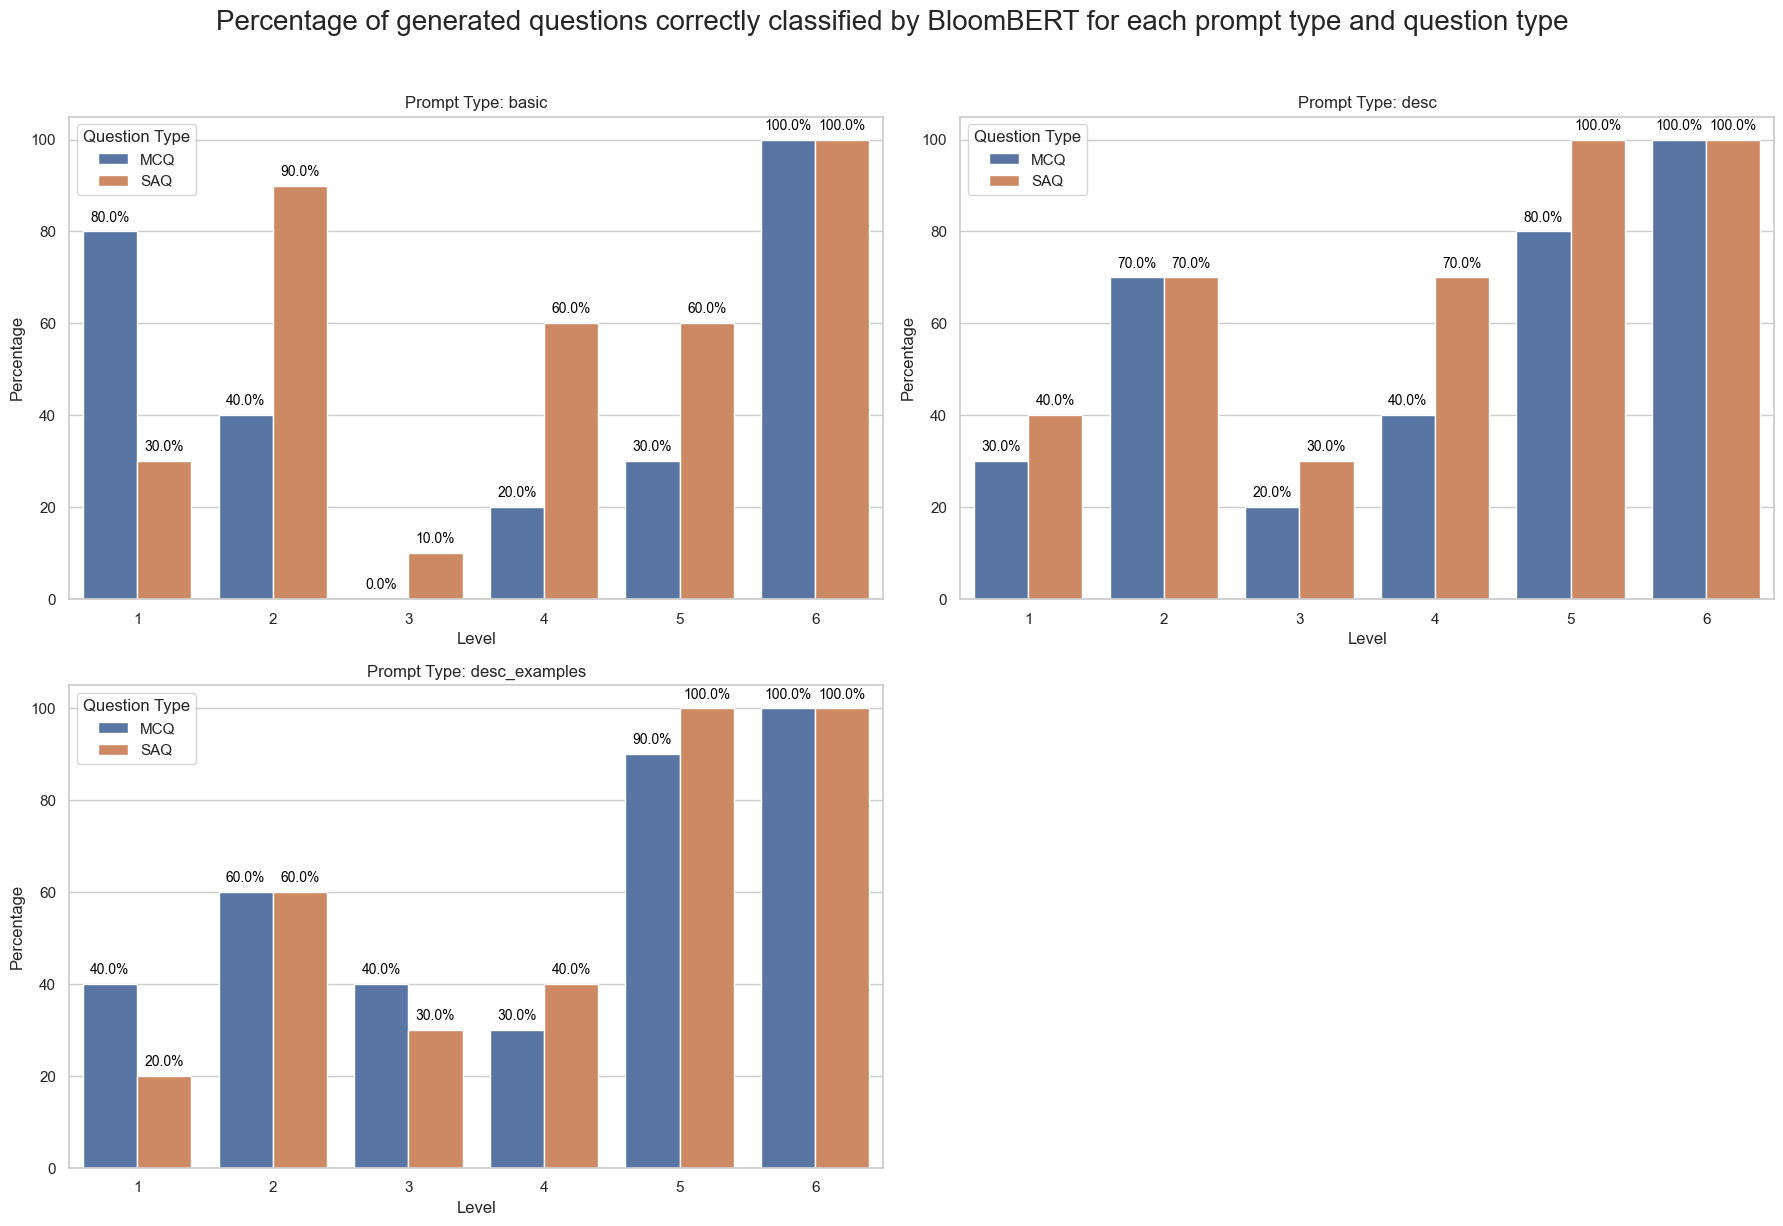

In [18]:
# Plot the percentage of is_correct for each combination of question_type, prompt_type as bar plot with level on x-axis and percentage of is_correct on y-axis
plt.figure(figsize=(18, 12))
sns.set_theme(style="whitegrid")

# Create a separate plot for each prompt type
for i, prompt in enumerate(prompt_types, 1):
    plt.subplot(2, 2, i)
    ax = sns.barplot(
        data=df[df['prompt_type'] == prompt],
        x='level',
        y='is_correct',
        hue='question_type',
        errorbar=None,
        estimator=lambda x: np.mean(x) * 100
    )
    plt.title(f'Prompt Type: {prompt}')
    plt.xlabel('Level')
    plt.ylabel('Percentage')
    plt.legend(title='Question Type')

    # Add percentage values above each bar
    for i in range(6):
        for j in range(2):
            bar = ax.patches[i * 2 + j]
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2., height), 
                        ha='center', va='bottom', 
                        fontsize=10, color='black', 
                        xytext=(0, 5), 
                        textcoords='offset points')
        
plt.suptitle('Percentage of generated questions correctly classified by BloomBERT for each prompt type and question type', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

### Generate question with refining

In [34]:
question = bloom_generator.generate_question(chunks[0], question_type="MCQ", level=3, prompt_type="desc", refine=True)
print(json.dumps(question, indent=2))

Refining question: Which of the following scenarios best illustrates the application of AI in maximizing goal achievement through environmental perception and learning? (predicted level: 2, ground truth level: 3)
{
  "question": "Which of the following actions demonstrates the application of AI in enhancing goal achievement through environmental perception and adaptive learning?",
  "choices": {
    "A": "A software that organizes files on a computer based on user-defined rules.",
    "B": "An online platform that curates personalized movie recommendations based on viewing history and preferences.",
    "C": "A digital clock that adjusts its brightness based on ambient light levels.",
    "D": "A calculator app that solves mathematical equations entered by the user."
  },
  "answer": "B"
}


In [35]:
bloom_generator.evaluate_question(question["question"], level=3)

(3, True)

In [21]:
# Create a DataFrame with col names: 'question_type', 'prompt_type', 'gen_question', 'level', 'predicted_level', 'is_correct' 
# with 10 records for each combination of question_type, prompt_type, and level

question_types = ['MCQ', 'SAQ']
prompt_types = ['basic', 'desc', 'desc_examples']
levels = range(1, 7)

data = []
for question_type in tqdm(question_types, desc="Question Types"):
    for prompt_type in tqdm(prompt_types, desc="Prompt Types"):
        for level in tqdm(levels, desc="Levels"):
            for _ in range(10):
                random_chunk = np.random.choice(chunks)
                question = bloom_generator.generate_question(random_chunk, question_type=question_type, level=level, prompt_type=prompt_type, refine=True)
                predicted_level, is_correct = bloom_generator.evaluate_question(question['question'], level)
                data.append([question_type, prompt_type, question, level, predicted_level, is_correct])

df = pd.DataFrame(data, columns=['question_type', 'prompt_type', 'gen_question', 'level', 'predicted_level', 'is_correct'])

Question Types:   0%|          | 0/2 [00:00<?, ?it/s]

Prompt Types:   0%|          | 0/3 [00:00<?, ?it/s]

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Refining question: What is one of the criticisms of sub-symbolic AI as argued by critics like Noam Chomsky? (predicted level: 2, ground truth level: 1)
Refining question: What does the field of machine perception involve? (predicted level: 2, ground truth level: 1)
Refining question: What type of search in AI involves searching through a tree of possible states to try to find a goal state? (predicted level: 2, ground truth level: 1)
Refining question: What factors contributed to the success of deep learning? (predicted level: 4, ground truth level: 1)
Refining question: What are some of the applications of artificial intelligence in the field of astronomy? (predicted level: 2, ground truth level: 1)
Refining question: Which international organization created the first legally binding treaty on AI, titled 'Framework Convention on Artificial Intelligence and Human Rights, Democracy and the Rule of Law'? (predicted level: 6, ground truth level: 1)
Refining question: Which type of jobs are

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Refining question: What factors contributed to the success of deep learning? (predicted level: 4, ground truth level: 1)
Refining question: Which AI pioneer did not sign the joint statement in 2023 that emphasized mitigating the risk of extinction from AI as a global priority? (predicted level: 5, ground truth level: 1)
Refining question: What are some of the subfields of artificial intelligence where deep learning has significantly improved program performance? (predicted level: 2, ground truth level: 1)
Refining question: What approach to artificial intelligence saw unprecedented success in the 2010s? (predicted level: 6, ground truth level: 1)
Refining question: What can be a potential consequence of a biased algorithm in fields such as medicine, finance, recruitment, housing or policing? (predicted level: 4, ground truth level: 2)
Refining question: What significant forecast did the International Energy Agency make in their 'Electricity 2024, Analysis and Forecast to 2026' report? 

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Refining question: Who first proposed the idea that 'artificial intelligence is the next step in evolution'? (predicted level: 6, ground truth level: 1)
Refining question: Which companies are known to dominate the commercial AI scene? (predicted level: 2, ground truth level: 1)
Refining question: Which companies are known to dominate the commercial AI scene? (predicted level: 2, ground truth level: 1)
Refining question: Who among the following AI experts did not sign the joint statement in 2023 emphasizing that mitigating the risk of extinction from AI should be a global priority? (predicted level: 5, ground truth level: 1)
Refining question: What percentage of newly funded startups in 2024 identified themselves as AI companies, based on PitchBook research? (predicted level: 4, ground truth level: 2)
Refining question: What is the main purpose of developing and studying methods and software in the field of artificial intelligence? (predicted level: 1, ground truth level: 2)
Refining qu

Prompt Types:   0%|          | 0/3 [00:00<?, ?it/s]

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Refining question: What was the issue with Google Photos's new image labeling feature that was identified on June 28, 2015, and how did Google attempt to fix it? (predicted level: 2, ground truth level: 1)
Refining question: What are some of the specific problems that natural language processing aims to solve? (predicted level: 2, ground truth level: 1)
Refining question: What is one of the criticisms of sub-symbolic reasoning in artificial intelligence? (predicted level: 2, ground truth level: 1)
Refining question: How does the philosophy of computationalism perceive the human mind and what is its stance on the mind-body problem? (predicted level: 4, ground truth level: 2)
Refining question: How does artificial intelligence contribute to the field of agriculture? (predicted level: 4, ground truth level: 2)
Refining question: What could be a potential issue in an organization or a process if there is a lack of transparency? (predicted level: 5, ground truth level: 2)
Refining question:

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Refining question: Who proposed the theory of computation that suggested a machine could simulate any conceivable form of mathematical reasoning? (predicted level: 6, ground truth level: 1)
Refining question: What is the purpose of using gradient descent in local search? (predicted level: 2, ground truth level: 1)
Refining question: What type of learning did the AI agent use to win a PlayStation Gran Turismo competition in 2021? (predicted level: 2, ground truth level: 1)
Refining question: What significant forecast did the International Energy Agency (IEA) make in their report 'Electricity 2024, Analysis and Forecast to 2026'? (predicted level: 5, ground truth level: 1)
Refining question: Who coined the term 'Friendly AI' and argued for its higher research priority? (predicted level: 5, ground truth level: 1)
Refining question: What are some of the applications of AI and machine learning technology in the 2020s? (predicted level: 2, ground truth level: 1)
Refining question: What is on

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Refining question: What is one of the criticisms of sub-symbolic AI as argued by critics like Noam Chomsky? (predicted level: 2, ground truth level: 1)
Refining question: What is the meaning of 'intelligence amplification' in the context of artificial intelligence? (predicted level: 2, ground truth level: 1)
Refining question: What type of processing units replaced central processing units as the dominant means for large-scale machine learning models' training in the late 2010s? (predicted level: 2, ground truth level: 1)
Refining question: What are some of the applications of artificial intelligence in the field of astronomy? (predicted level: 2, ground truth level: 1)
Refining question: What types of sensitive user data might be collected by AI-powered devices and services? (predicted level: 2, ground truth level: 1)
Refining question: What was the European Union's consideration regarding AI systems in 2017? (predicted level: 2, ground truth level: 1)
Refining question: Who are some 

In [22]:
df.to_csv('questions_refining.csv', index=False)

In [23]:
# For each pompt type, print the percentage of is_correct regardless of question type and level
for prompt_type in prompt_types:
    prompt_df = df[df['prompt_type'] == prompt_type]
    correct_percentage = prompt_df['is_correct'].mean() * 100
    print(f"Prompt Type: {prompt_type}, Correct Percentage: {correct_percentage:.2f}%")


Prompt Type: basic, Correct Percentage: 73.33%
Prompt Type: desc, Correct Percentage: 80.00%
Prompt Type: desc_examples, Correct Percentage: 72.50%


In [24]:
# For each pompt type, print the percentage of is_correct depending on question type
for prompt in prompt_types:
    print(f'Prompt Type: {prompt}')
    for question_type in question_types:
        percentage = df[(df['prompt_type'] == prompt) & (df['question_type'] == question_type)]['is_correct'].mean() * 100
        print(f'Question Type: {question_type}, Percentage of generated questions correctly classified with refining: {percentage:.2f}%')
    print('\n')

Prompt Type: basic
Question Type: MCQ, Percentage of generated questions correctly classified with refining: 65.00%
Question Type: SAQ, Percentage of generated questions correctly classified with refining: 81.67%


Prompt Type: desc
Question Type: MCQ, Percentage of generated questions correctly classified with refining: 76.67%
Question Type: SAQ, Percentage of generated questions correctly classified with refining: 83.33%


Prompt Type: desc_examples
Question Type: MCQ, Percentage of generated questions correctly classified with refining: 76.67%
Question Type: SAQ, Percentage of generated questions correctly classified with refining: 68.33%




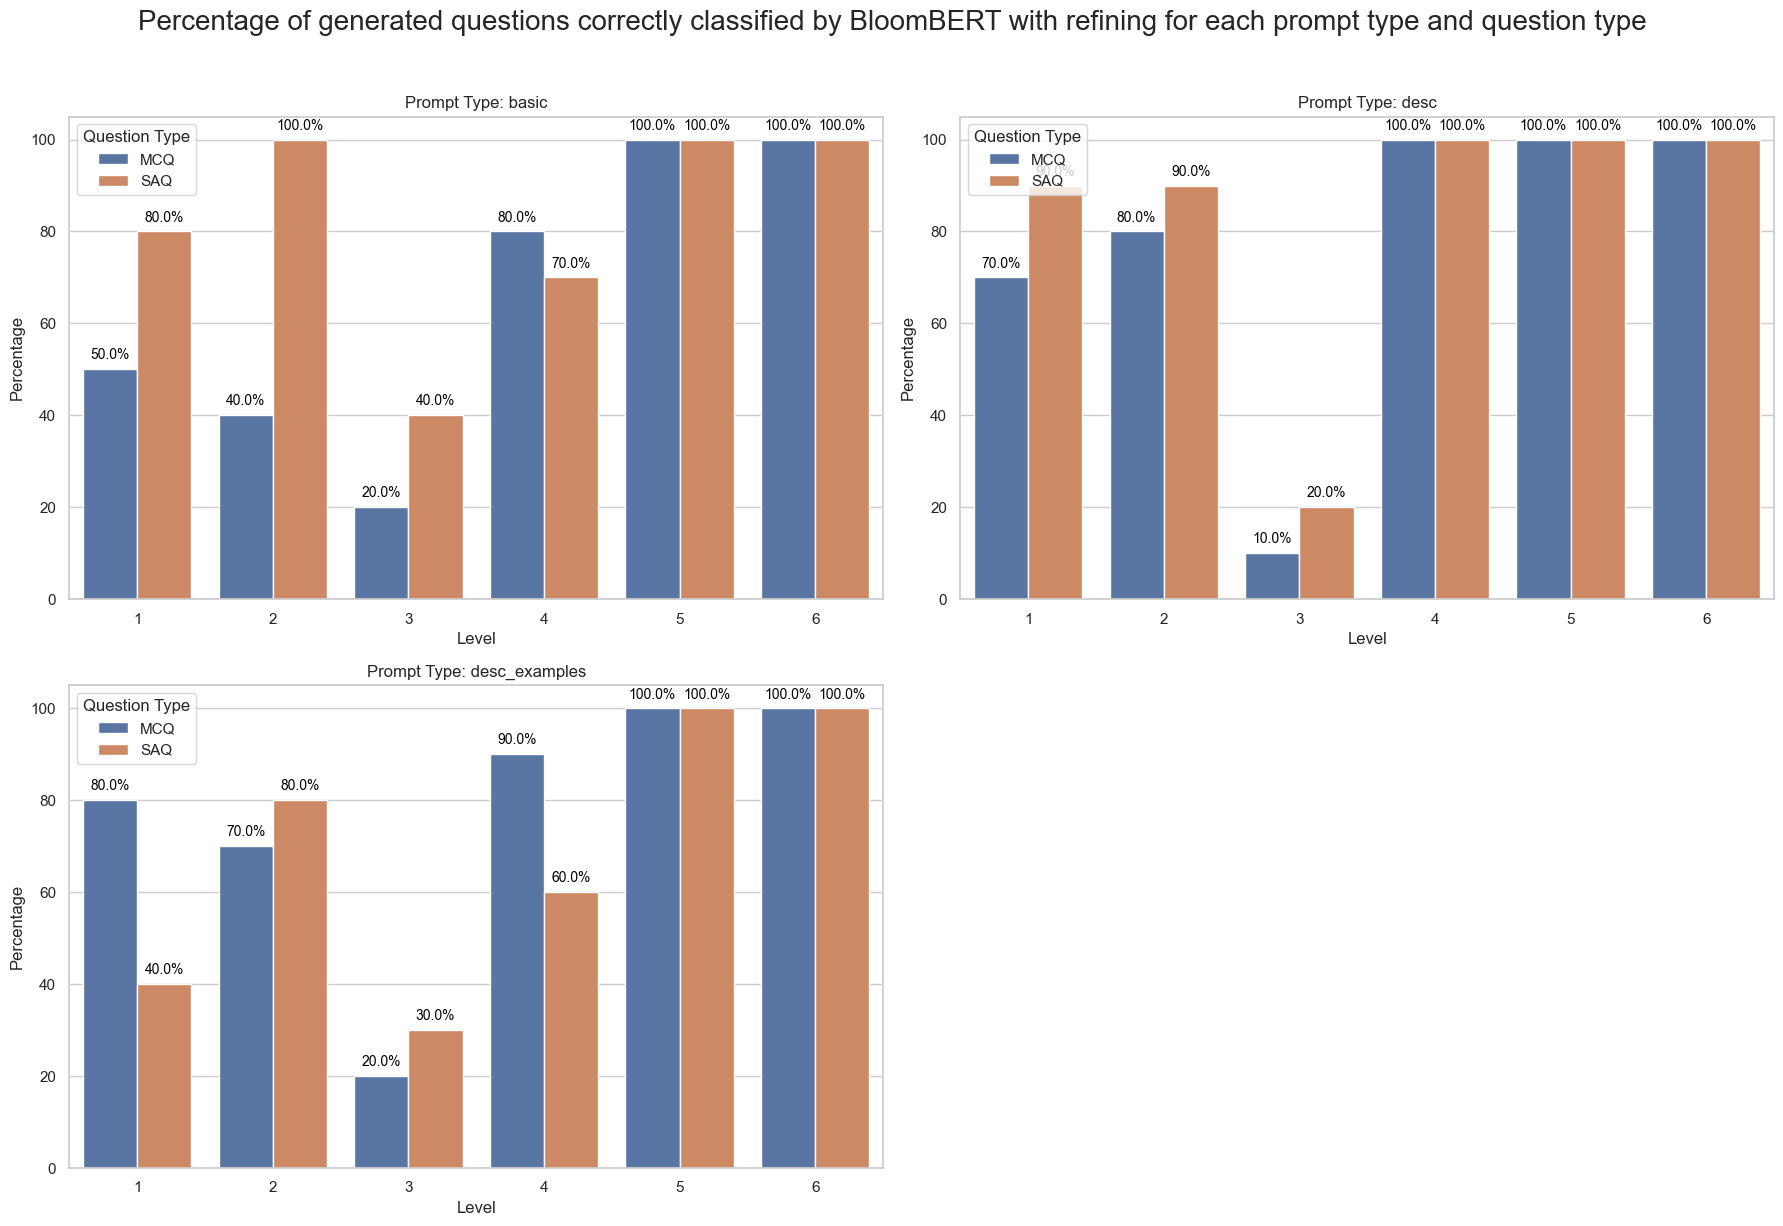

In [ ]:
# Plot the percentage of is_correct for each combination of question_type, prompt_type as bar plot with level on x-axis and percentage of is_correct on y-axis
plt.figure(figsize=(18, 12))
sns.set_theme(style="whitegrid")

# Create a separate plot for each prompt type
for i, prompt in enumerate(prompt_types, 1):
    plt.subplot(2, 2, i)
    ax = sns.barplot(
        data=df[df['prompt_type'] == prompt],
        x='level',
        y='is_correct',
        hue='question_type',
        errorbar=None,
        estimator=lambda x: np.mean(x) * 100
    )
    plt.title(f'Prompt Type: {prompt}')
    plt.xlabel('Level')
    plt.ylabel('Percentage')
    plt.legend(title='Question Type')

    # Add percentage values above each bar
    for i in range(6):
        for j in range(2):
            bar = ax.patches[i * 2 + j]
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2., height), 
                        ha='center', va='bottom', 
                        fontsize=10, color='black', 
                        xytext=(0, 5), 
                        textcoords='offset points')
        
plt.suptitle('Percentage of generated questions correctly classified by BloomBERT with refining for each prompt type and question type', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

### LLM as a Judge

In [36]:
# Teat MCQ question (no llm)
question = bloom_generator.generate_question(chunks[0], question_type="MCQ", level=2, prompt_type="desc")
print(json.dumps(question, indent=2))

{
  "question": "What is a key characteristic of artificial intelligence as described in the context?",
  "choices": {
    "A": "AI systems are only used for entertainment purposes.",
    "B": "AI is primarily focused on replacing human jobs.",
    "C": "AI involves machines perceiving their environment and learning to achieve goals.",
    "D": "AI is exclusively used in military applications."
  },
  "answer": "C"
}


In [37]:
print(bloom_generator.check_answer_mcq(question, question['answer']))
print(bloom_generator.check_answer_mcq(question, "B"))

True
False


In [38]:
question = bloom_generator.generate_question(chunks[0], question_type="SAQ", level=2, prompt_type="desc")
print(json.dumps(question, indent=2))

{
  "question": "What is artificial intelligence and how do machines utilize it to achieve their goals?",
  "correct_answer": "Artificial intelligence is intelligence exhibited by machines, particularly computer systems, enabling them to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.",
  "incorrect_answer": "Artificial intelligence is when computers are used for basic calculations and data storage without any learning or adaptation."
}


In [39]:
bloom_generator.check_answer_saq(chunks[0], question['question'], question['correct_answer'])

(True,
 'Your answer accurately describes artificial intelligence as the intelligence exhibited by machines and explains how they use learning and intelligence to achieve defined goals. Well done!')

In [40]:
bloom_generator.check_answer_saq(chunks[0], question['question'], question['incorrect_answer'])

(False,
 'Your answer does not accurately describe artificial intelligence. AI involves machines that can learn, adapt, and make decisions to achieve specific goals, not just perform basic calculations or store data. Consider how AI systems use perception, learning, and intelligence to optimize their actions.')

### Human validation

In [29]:
# Generate 12 SAQ questions, 2 for each level, evaluate them with BloomBERT and save the results in two csv files:
# One with the results of the evaluation and one with only the questions

levels = range(1, 7)

data = []

for level in tqdm(levels, desc="Levels"):
    for _ in range(2):
        random_chunk = np.random.choice(chunks)
        question = bloom_generator.generate_question(random_chunk, question_type="SAQ", level=level, prompt_type="desc")
        predicted_level, _ = bloom_generator.evaluate_question(question['question'], level)
        data.append([question['question'], random_chunk, level, predicted_level, question['correct_answer'], question['incorrect_answer']])

df = pd.DataFrame(data, columns=['question', 'chunk', 'level', 'predicted_level', 'correct_answer', 'incorrect_answer'])
        

Levels:   0%|          | 0/6 [00:00<?, ?it/s]

In [30]:
df

,question,chunk,level,predicted_level,correct_answer,incorrect_answer
0,What is a knowledge base in the context of art...,Knowledge representation and knowledge enginee...,1,1,A knowledge base is a body of knowledge repres...,A knowledge base is a database that stores inf...
1,What is a lethal autonomous weapon?,Artificial intelligence provides a number of t...,1,1,A lethal autonomous weapon is a machine that l...,A lethal autonomous weapon is a machine that i...
2,What are some of the techniques AI developers ...,AI developers argue that this is the only way ...,2,2,AI developers use techniques such as data aggr...,AI developers use techniques such as data encr...
3,What does it mean when a system or organizatio...,==== Lack of transparency ====,2,2,"It means that the actions, decisions, or proce...",It means that the system or organization is ph...
4,Imagine you are the head of a large technology...,Prodigious power consumption by AI is responsi...,3,6,Strategies could include investing in renewabl...,Strategies could include increasing the use of...
5,Imagine you are the owner of a website and you...,Generative AI is often trained on unlicensed c...,3,3,I could indicate my wishes not to have my cont...,I could sue the AI companies for using my work.
6,How might the demographic makeup of AI enginee...,Criticism of COMPAS highlighted that machine l...,4,4,"The demographic makeup of AI engineers, being ...",The demographic makeup of AI engineers has no ...
7,Compare and contrast the processes of automate...,"=== Planning and decision-making ===\nAn ""agen...",4,4,"In automated planning, a rational agent has a ...",In both automated planning and decision-making...
8,Based on the various definitions of intelligen...,Russell and Norvig agree with Turing that inte...,5,4,Strengths might include that it focuses on pra...,Strengths include that it requires the machine...
9,Based on the ethical principles outlined and t...,Respect the dignity of individual people\nConn...,5,5,The effectiveness of the 'Inspect' toolset can...,The 'Inspect' toolset's effectiveness can be e...


In [31]:
# shuffle the rows of the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df

,question,chunk,level,predicted_level,correct_answer,incorrect_answer
0,Compare and contrast the processes of automate...,"=== Planning and decision-making ===\nAn ""agen...",4,4,"In automated planning, a rational agent has a ...",In both automated planning and decision-making...
1,Imagine you are tasked with developing a new A...,"Alternatively, dedicated models for mathematic...",6,6,I would start by studying the strengths and we...,I would just combine all the existing models i...
2,What are some of the techniques AI developers ...,AI developers argue that this is the only way ...,2,2,AI developers use techniques such as data aggr...,AI developers use techniques such as data encr...
3,How might the demographic makeup of AI enginee...,Criticism of COMPAS highlighted that machine l...,4,4,"The demographic makeup of AI engineers, being ...",The demographic makeup of AI engineers has no ...
4,What is a lethal autonomous weapon?,Artificial intelligence provides a number of t...,1,1,A lethal autonomous weapon is a machine that l...,A lethal autonomous weapon is a machine that i...
5,What does it mean when a system or organizatio...,==== Lack of transparency ====,2,2,"It means that the actions, decisions, or proce...",It means that the system or organization is ph...
6,Based on the various definitions of intelligen...,Russell and Norvig agree with Turing that inte...,5,4,Strengths might include that it focuses on pra...,Strengths include that it requires the machine...
7,Imagine you are the head of a large technology...,Prodigious power consumption by AI is responsi...,3,6,Strategies could include investing in renewabl...,Strategies could include increasing the use of...
8,What is a knowledge base in the context of art...,Knowledge representation and knowledge enginee...,1,1,A knowledge base is a body of knowledge repres...,A knowledge base is a database that stores inf...
9,Based on the ethical principles outlined and t...,Respect the dignity of individual people\nConn...,5,5,The effectiveness of the 'Inspect' toolset can...,The 'Inspect' toolset's effectiveness can be e...


In [32]:
# Create a column "random_answer" with randomly either the correct answer or the incorrect answer
df['random_answer'] = df.apply(lambda x: x['correct_answer'] if np.random.rand() < 0.5 else x['incorrect_answer'], axis=1)
df

,question,chunk,level,predicted_level,correct_answer,incorrect_answer,random_answer
0,Compare and contrast the processes of automate...,"=== Planning and decision-making ===\nAn ""agen...",4,4,"In automated planning, a rational agent has a ...",In both automated planning and decision-making...,"In automated planning, a rational agent has a ..."
1,Imagine you are tasked with developing a new A...,"Alternatively, dedicated models for mathematic...",6,6,I would start by studying the strengths and we...,I would just combine all the existing models i...,I would just combine all the existing models i...
2,What are some of the techniques AI developers ...,AI developers argue that this is the only way ...,2,2,AI developers use techniques such as data aggr...,AI developers use techniques such as data encr...,AI developers use techniques such as data encr...
3,How might the demographic makeup of AI enginee...,Criticism of COMPAS highlighted that machine l...,4,4,"The demographic makeup of AI engineers, being ...",The demographic makeup of AI engineers has no ...,"The demographic makeup of AI engineers, being ..."
4,What is a lethal autonomous weapon?,Artificial intelligence provides a number of t...,1,1,A lethal autonomous weapon is a machine that l...,A lethal autonomous weapon is a machine that i...,A lethal autonomous weapon is a machine that l...
5,What does it mean when a system or organizatio...,==== Lack of transparency ====,2,2,"It means that the actions, decisions, or proce...",It means that the system or organization is ph...,It means that the system or organization is ph...
6,Based on the various definitions of intelligen...,Russell and Norvig agree with Turing that inte...,5,4,Strengths might include that it focuses on pra...,Strengths include that it requires the machine...,Strengths include that it requires the machine...
7,Imagine you are the head of a large technology...,Prodigious power consumption by AI is responsi...,3,6,Strategies could include investing in renewabl...,Strategies could include increasing the use of...,Strategies could include increasing the use of...
8,What is a knowledge base in the context of art...,Knowledge representation and knowledge enginee...,1,1,A knowledge base is a body of knowledge repres...,A knowledge base is a database that stores inf...,A knowledge base is a database that stores inf...
9,Based on the ethical principles outlined and t...,Respect the dignity of individual people\nConn...,5,5,The effectiveness of the 'Inspect' toolset can...,The 'Inspect' toolset's effectiveness can be e...,The effectiveness of the 'Inspect' toolset can...


In [33]:
# Save the whole DataFrame to a csv file
df.to_csv('SAQ_questions_labels_v2.csv', index=False)

In [34]:
# Save only the df with columns: 'question', 'random_answer' and the columns "level", "is_corret" with NaN values
guess_df = df[['question', 'chunk', 'random_answer']].copy()
guess_df['level'] = np.nan
guess_df['is_correct'] = np.nan
guess_df.to_csv('SAQ_questions_labels_guess.csv', index=False)
guess_df

,question,chunk,random_answer,level,is_correct
0,Compare and contrast the processes of automate...,"=== Planning and decision-making ===\nAn ""agen...","In automated planning, a rational agent has a ...",NaN,NaN
1,Imagine you are tasked with developing a new A...,"Alternatively, dedicated models for mathematic...",I would just combine all the existing models i...,NaN,NaN
2,What are some of the techniques AI developers ...,AI developers argue that this is the only way ...,AI developers use techniques such as data encr...,NaN,NaN
3,How might the demographic makeup of AI enginee...,Criticism of COMPAS highlighted that machine l...,"The demographic makeup of AI engineers, being ...",NaN,NaN
4,What is a lethal autonomous weapon?,Artificial intelligence provides a number of t...,A lethal autonomous weapon is a machine that l...,NaN,NaN
5,What does it mean when a system or organizatio...,==== Lack of transparency ====,It means that the system or organization is ph...,NaN,NaN
6,Based on the various definitions of intelligen...,Russell and Norvig agree with Turing that inte...,Strengths include that it requires the machine...,NaN,NaN
7,Imagine you are the head of a large technology...,Prodigious power consumption by AI is responsi...,Strategies could include increasing the use of...,NaN,NaN
8,What is a knowledge base in the context of art...,Knowledge representation and knowledge enginee...,A knowledge base is a database that stores inf...,NaN,NaN
9,Based on the ethical principles outlined and t...,Respect the dignity of individual people\nConn...,The effectiveness of the 'Inspect' toolset can...,NaN,NaN


In [35]:
# add column "is_correct" with True if the answer is correct, False if the answer is incorrect
guess_df['is_correct'] = df.apply(lambda x: x['correct_answer'] == x['random_answer'], axis=1)
guess_df

,question,chunk,random_answer,level,is_correct
0,Compare and contrast the processes of automate...,"=== Planning and decision-making ===\nAn ""agen...","In automated planning, a rational agent has a ...",NaN,True
1,Imagine you are tasked with developing a new A...,"Alternatively, dedicated models for mathematic...",I would just combine all the existing models i...,NaN,False
2,What are some of the techniques AI developers ...,AI developers argue that this is the only way ...,AI developers use techniques such as data encr...,NaN,False
3,How might the demographic makeup of AI enginee...,Criticism of COMPAS highlighted that machine l...,"The demographic makeup of AI engineers, being ...",NaN,True
4,What is a lethal autonomous weapon?,Artificial intelligence provides a number of t...,A lethal autonomous weapon is a machine that l...,NaN,True
5,What does it mean when a system or organizatio...,==== Lack of transparency ====,It means that the system or organization is ph...,NaN,False
6,Based on the various definitions of intelligen...,Russell and Norvig agree with Turing that inte...,Strengths include that it requires the machine...,NaN,False
7,Imagine you are the head of a large technology...,Prodigious power consumption by AI is responsi...,Strategies could include increasing the use of...,NaN,False
8,What is a knowledge base in the context of art...,Knowledge representation and knowledge enginee...,A knowledge base is a database that stores inf...,NaN,False
9,Based on the ethical principles outlined and t...,Respect the dignity of individual people\nConn...,The effectiveness of the 'Inspect' toolset can...,NaN,True


In [40]:
# Add column predicted_is_correct with True if the llm predicted the answer correctly, False if the llm predicted the answer incorrectly
# Use the check_answer_saq function from BloomQuestionGenerator to check the answer
# and add column feedback with the feedback from the llm

guess_df['predicted_is_correct'] = guess_df.apply(lambda x: bloom_generator.check_answer_saq(x['chunk'], x['question'], x['random_answer'])[0], axis=1)
guess_df['feedback'] = guess_df.apply(lambda x: bloom_generator.check_answer_saq(x['chunk'], x['question'], x['random_answer'])[1], axis=1)
guess_df

,question,chunk,random_answer,level,is_correct,predicted_is_correct,feedback
0,Compare and contrast the processes of automate...,"=== Planning and decision-making ===\nAn ""agen...","In automated planning, a rational agent has a ...",NaN,True,True,Great job! Your answer accurately describes th...
1,Imagine you are tasked with developing a new A...,"Alternatively, dedicated models for mathematic...",I would just combine all the existing models i...,NaN,False,False,Your approach to simply combine all the existi...
2,What are some of the techniques AI developers ...,AI developers argue that this is the only way ...,AI developers use techniques such as data encr...,NaN,False,False,Your answer is not quite correct. The techniqu...
3,How might the demographic makeup of AI enginee...,Criticism of COMPAS highlighted that machine l...,"The demographic makeup of AI engineers, being ...",NaN,True,True,Excellent job! You correctly identified how th...
4,What is a lethal autonomous weapon?,Artificial intelligence provides a number of t...,A lethal autonomous weapon is a machine that l...,NaN,True,True,Great job! Your definition of a lethal autonom...
5,What does it mean when a system or organizatio...,==== Lack of transparency ====,It means that the system or organization is ph...,NaN,False,False,Your answer is incorrect. When a system or org...
6,Based on the various definitions of intelligen...,Russell and Norvig agree with Turing that inte...,Strengths include that it requires the machine...,NaN,False,False,Your answer doesn't align with the text. The s...
7,Imagine you are the head of a large technology...,Prodigious power consumption by AI is responsi...,Strategies could include increasing the use of...,NaN,False,False,Your answer seems to contradict the goal of re...
8,What is a knowledge base in the context of art...,Knowledge representation and knowledge enginee...,A knowledge base is a database that stores inf...,NaN,False,False,Your answer is partially correct. A knowledge ...
9,Based on the ethical principles outlined and t...,Respect the dignity of individual people\nConn...,The effectiveness of the 'Inspect' toolset can...,NaN,True,True,Great job! Your answer correctly identifies th...


In [41]:
# save guess_df to a csv file
guess_df.to_csv('SAQ_questions_labels_guess_with_feedback.csv', index=False)

## Generation from PDF

In [23]:
pdf_path = "../data/courses/MIT18_S096F15_Ses2_4.pdf"
pdf_chunker = PDFChunker(pdf_path=pdf_path)

In [24]:
formated_chunks = pdf_chunker.formated_chunks
formated_chunks[4]

[Document(metadata={'type': 'text'}, page_content='1.2 PCA in high dimensions and Marcenko-Pastur'),
 Document(metadata={'type': 'text'}, page_content='Let us assume that the data points x 1,...,xn ∈ R are independent draws of a gaussian random p variable g ∼ N(0,Σ) for some covariance Σ ∈ Rp×p. In this case when we use PCA we are hoping to ﬁnd low dimensional structure in the distribution, which should correspond to large eigenvalues of Σ (and their corresponding eigenvectors). For this reason (and since PCA depends on the spectral properties of Σn) we would like to understand whether the spectral properties of Σn (eigenvalues and eigenvectors) are close to the ones of Σ.'),
 Document(metadata={'type': 'text'}, page_content='Since EΣn = Σ, if p is ﬁxed and n → ∞ the law of large numbers guarantees that indeed Σn → Σ. However, in many modern applications it is not uncommon to have p in the order of n (or, sometimes, even larger!). For example, if our dataset is composed by images then 

In [26]:
bloom_generator = BloomQuestionGenerator(model="gpt-4o")
question_dict = bloom_generator.generate_question(formated_chunks[0], question_type="MCQ", level=1)
question_dict

{'question': 'Who introduced Principal Component Analysis (PCA) in a 1901 paper?',
 'choices': {'A': 'Ronald Fisher',
  'B': 'Karl Pearson',
  'C': 'John Tukey',
  'D': 'Francis Galton'},
 'answer': 'B'}

In [27]:
question_dict = bloom_generator.generate_question(formated_chunks[4], question_type="MCQ", level=1)
question_dict

{'question': 'What is the relationship between p and n in the context of the Marchenko-Pastur distribution?',
 'choices': {'A': 'p is much smaller than n',
  'B': 'p is much larger than n',
  'C': 'p and n are both going to infinity with their ratio fixed',
  'D': 'p and n are unrelated'},
 'answer': 'C'}

In [28]:
question_dict = bloom_generator.generate_question(formated_chunks[4], question_type="SAQ", level=1)
question_dict

{'question': 'What is the distribution called that describes the sample distribution of eigenvalues of Sn when p and n both go to infinity with a fixed ratio?',
 'correct_answer': 'Marchenko-Pastur distribution',
 'incorrect_answer': 'Gaussian distribution'}